In [1]:
!pip install stim

In [2]:
import numpy as np
import stim

N = 10_000_000

p_raw_entanglement = 0.02859
p_SPAM = 0.00502

single_qubit_op_scale = 4/3
two_qubit_op_scale = 16/15

p_Alice = {
    "Prep Q_n |0>": 0.00266,
    "Prep Q_n |1>": 0.00788,
    "Prep Q_c |0>": 0.00859,
    "Prep Q_c |1>": 0.00646,
    "Prep Q_x |0>": 0.00477,
    "Prep Q_x |1>": 0.00364,
    "Mixed-spices gate": 0.0252 * two_qubit_op_scale,
    "Q_c decoherence": 0.0194 * single_qubit_op_scale,
    "Q_x <-> Q_c transfer": 0.00763 * two_qubit_op_scale,
    "Mid-circuit measurement": 0.000913,
    "Q_c rotations": 0.000161 * single_qubit_op_scale,
}

p_Bob = {
    "Prep Q_n |0>": 0.00658,
    "Prep Q_n |1>": 0.00456,
    "Prep Q_c |0>": 0.00608,
    "Prep Q_c |1>": 0.00756,
    "Prep Q_x |0>": 0.00327,
    "Prep Q_x |1>": 0.00535,
    "Mixed-spices gate": 0.0202 * two_qubit_op_scale,
    "Q_c decoherence": 0.0185 * single_qubit_op_scale,
    "Q_x <-> Q_c transfer": 0.00521 * two_qubit_op_scale,
    "Mid-circuit measurement": 0.001222,
    "Q_c rotations": 0.000151 * single_qubit_op_scale,
}


In [3]:
def bell_fidelity(circuit, q0, q1, N):
    # Measure in XX basis
    xx_circuit = circuit + stim.Circuit(f"H {q0} {q1}\nM {q0} {q1}")
    xx_samples = xx_circuit.compile_sampler().sample(N)
    exp_xx = np.mean((1 - 2 * xx_samples[:, -2]) * (1 - 2 * xx_samples[:, -1]))

    # Measure in ZZ basis
    zz_circuit = circuit + stim.Circuit(f"M {q0} {q1}")
    zz_samples = zz_circuit.compile_sampler().sample(N)
    exp_zz = np.mean((1 - 2 * zz_samples[:, -2]) * (1 - 2 * zz_samples[:, -1]))

    # Measure in YY basis
    yy_circuit = circuit + stim.Circuit(f"S {q0} {q1}\nH {q0} {q1}\nM {q0} {q1}")
    yy_samples = yy_circuit.compile_sampler().sample(N)
    exp_yy = np.mean((1 - 2 * yy_samples[:, -2]) * (1 - 2 * yy_samples[:, -1]))

    fidelity = (1 + exp_xx + exp_zz - exp_yy) / 4
    return fidelity


circuit = stim.Circuit(f"""
    H 0
    CNOT 0 1
    DEPOLARIZE1({p_raw_entanglement}) 0
""")

print(f"Expected fidelity {1 - p_raw_entanglement:.2%}")
print(f"Sampled fidelity {bell_fidelity(circuit, 0, 1, N):.2%}")

Expected fidelity 97.14%
Sampled fidelity 97.14%


Expected fidelity: 86.19%
Sampled fidelity: 86.63%


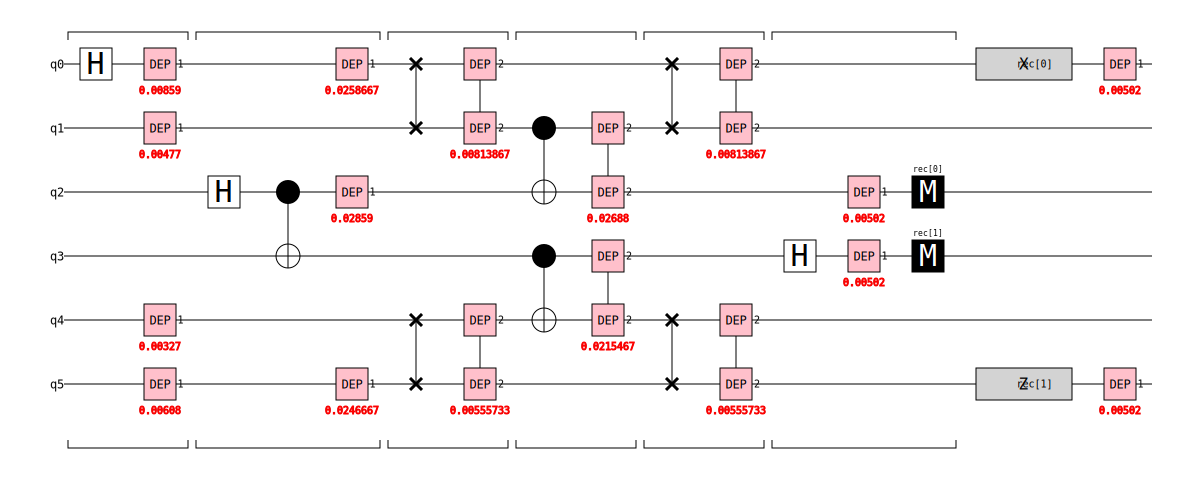

In [4]:
physical_bell_state_prep = stim.Circuit(f"""
    H 0
    DEPOLARIZE1({p_Alice['Prep Q_c |0>']}) 0
    DEPOLARIZE1({p_Alice['Prep Q_x |0>']}) 1
    DEPOLARIZE1({p_Bob['Prep Q_x |0>']}) 4
    DEPOLARIZE1({p_Bob['Prep Q_c |0>']}) 5
    TICK

    H 2
    CNOT 2 3
    DEPOLARIZE1({p_raw_entanglement}) 2
    DEPOLARIZE1({p_Alice['Q_c decoherence']}) 0
    DEPOLARIZE1({p_Bob['Q_c decoherence']}) 5

    TICK

    # Q_x <-> Q_c transfer for both Alice and Bob
    SWAP 0 1
    SWAP 4 5
    DEPOLARIZE2({p_Alice['Q_x <-> Q_c transfer']}) 0 1
    DEPOLARIZE2({p_Bob['Q_x <-> Q_c transfer']}) 4 5

    TICK

    # Mixed-spices gates
    CNOT 1 2
    CNOT 3 4
    DEPOLARIZE2({p_Alice['Mixed-spices gate']}) 1 2
    DEPOLARIZE2({p_Bob['Mixed-spices gate']}) 3 4

    TICK

    # Q_x <-> Q_c transfer for both Alice and Bob
    SWAP 0 1
    SWAP 4 5
    DEPOLARIZE2({p_Alice['Q_x <-> Q_c transfer']}) 0 1
    DEPOLARIZE2({p_Bob['Q_x <-> Q_c transfer']}) 4 5

    TICK

    H 3
    DEPOLARIZE1({p_SPAM}) 3 2
    M 2 3

    TICK

    CX rec[-2] 0
    CZ rec[-1] 5

    TICK

    DEPOLARIZE1({p_SPAM}) 0 5
""")

print(f"Expected fidelity: 86.19%")
print(f"Sampled fidelity: {bell_fidelity(physical_bell_state_prep, 0, 5, N):.2%}")

physical_bell_state_prep.diagram('timeline-svg')

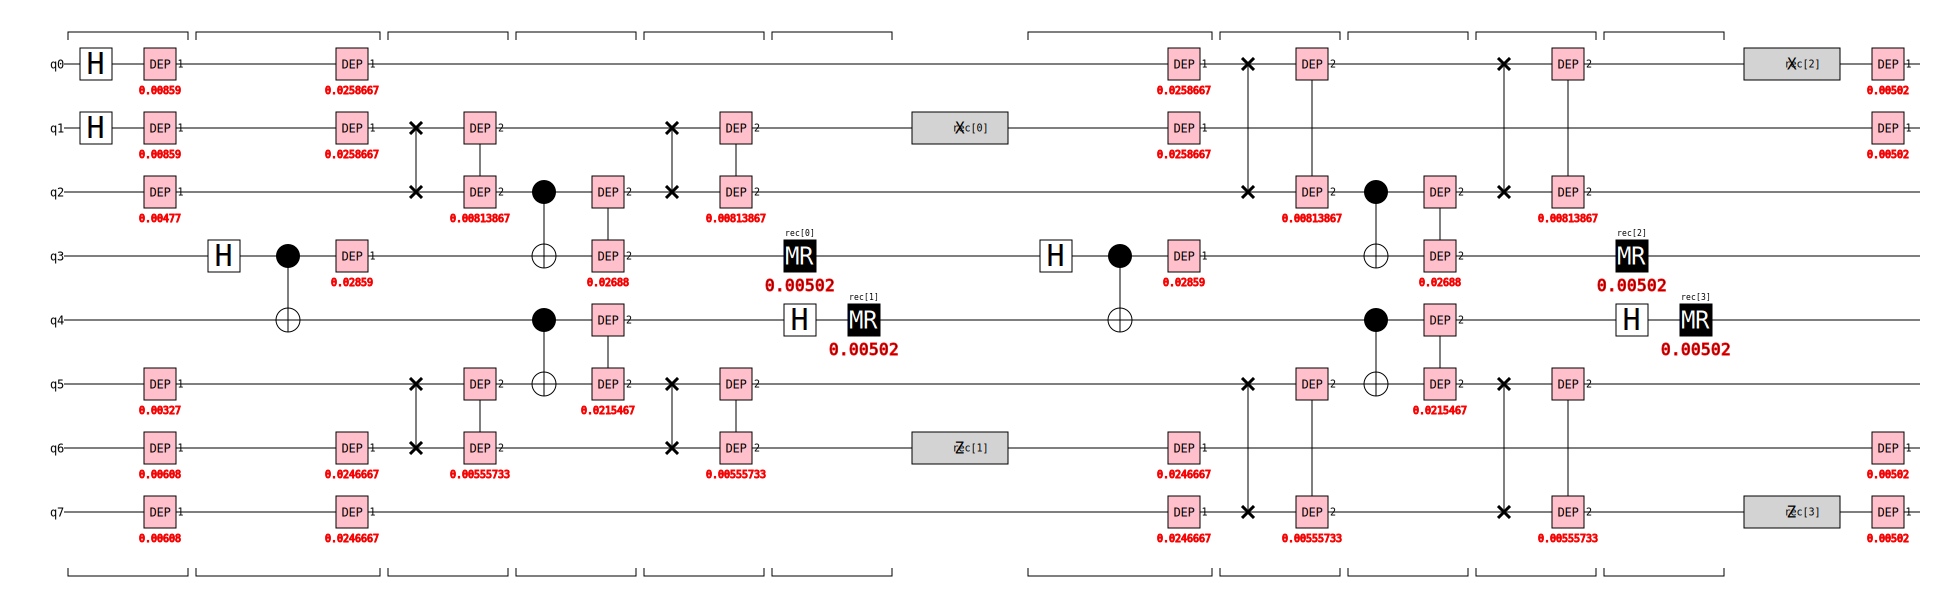

In [5]:
logical_bell_state_prep = stim.Circuit(f"""
    H 0
    H 1
    DEPOLARIZE1({p_Alice['Prep Q_c |0>']}) 0
    DEPOLARIZE1({p_Alice['Prep Q_c |0>']}) 1
    DEPOLARIZE1({p_Alice['Prep Q_x |0>']}) 2
    DEPOLARIZE1({p_Bob['Prep Q_x |0>']}) 5
    DEPOLARIZE1({p_Bob['Prep Q_c |0>']}) 6
    DEPOLARIZE1({p_Bob['Prep Q_c |0>']}) 7

    TICK

    H 3
    CNOT 3 4
    DEPOLARIZE1({p_raw_entanglement}) 3
    DEPOLARIZE1({p_Alice['Q_c decoherence']}) 0
    DEPOLARIZE1({p_Alice['Q_c decoherence']}) 1
    DEPOLARIZE1({p_Bob['Q_c decoherence']}) 6
    DEPOLARIZE1({p_Bob['Q_c decoherence']}) 7

    TICK

    # Q_x <-> Q_c transfer for both Alice and Bob
    SWAP 1 2
    SWAP 5 6
    DEPOLARIZE2({p_Alice['Q_x <-> Q_c transfer']}) 1 2
    DEPOLARIZE2({p_Bob['Q_x <-> Q_c transfer']}) 5 6

    TICK

    # Mixed-spices gates
    CNOT 2 3
    CNOT 4 5
    DEPOLARIZE2({p_Alice['Mixed-spices gate']}) 2 3
    DEPOLARIZE2({p_Bob['Mixed-spices gate']}) 4 5

    TICK

    # Q_x <-> Q_c transfer for both Alice and Bob
    SWAP 1 2
    SWAP 5 6
    DEPOLARIZE2({p_Alice['Q_x <-> Q_c transfer']}) 1 2
    DEPOLARIZE2({p_Bob['Q_x <-> Q_c transfer']}) 5 6

    TICK

    H 4
    MR({p_SPAM}) 3 4

    TICK

    CX rec[-2] 1
    CZ rec[-1] 6

    TICK

    H 3
    CNOT 3 4
    DEPOLARIZE1({p_raw_entanglement}) 3
    DEPOLARIZE1({p_Alice['Q_c decoherence']}) 0
    DEPOLARIZE1({p_Alice['Q_c decoherence']}) 1
    DEPOLARIZE1({p_Bob['Q_c decoherence']}) 6
    DEPOLARIZE1({p_Bob['Q_c decoherence']}) 7

    TICK

    # Q_x <-> Q_c transfer for both Alice and Bob
    SWAP 0 2
    SWAP 5 7
    DEPOLARIZE2({p_Alice['Q_x <-> Q_c transfer']}) 0 2
    DEPOLARIZE2({p_Bob['Q_x <-> Q_c transfer']}) 5 7

    TICK

    # Mixed-spices gates
    CNOT 2 3
    CNOT 4 5
    DEPOLARIZE2({p_Alice['Mixed-spices gate']}) 2 3
    DEPOLARIZE2({p_Bob['Mixed-spices gate']}) 4 5

    TICK

    # Q_x <-> Q_c transfer for both Alice and Bob
    SWAP 0 2
    SWAP 5 7
    DEPOLARIZE2({p_Alice['Q_x <-> Q_c transfer']}) 0 2
    DEPOLARIZE2({p_Bob['Q_x <-> Q_c transfer']}) 5 7

    TICK

    H 4
    MR({p_SPAM}) 3 4

    TICK

    CX rec[-2] 0
    CZ rec[-1] 7

    TICK

    DEPOLARIZE1({p_SPAM}) 0 1 6 7
""")

logical_bell_state_prep.diagram('timeline-svg')

In [6]:
def decode(samples):
    q0, q1 = samples[:, -4] ^ samples[:, -3], samples[:, -4] ^ samples[:, -2]
    valid = np.array((1 + np.sum(samples[:, -4:], axis=1)) % 2, dtype=bool)
    return q0[valid], q1[valid], sum(valid)


def logical_bell_fidelity(circuit, qubits, N):
    all_qubits = ' '.join(map(str, qubits))
    logical_H = stim.Circuit(f"H {all_qubits}\n SWAP {qubits[1]} {qubits[2]}")
    logical_S = stim.Circuit(f"S {all_qubits}")
    logical_M = stim.Circuit(f"M {all_qubits}")

    # Measure in XX basis
    xx_circuit = circuit + logical_H + logical_M
    xx_samples = xx_circuit.compile_sampler().sample(N)
    xx_q0, xx_q1, xx_valid = decode(xx_samples)
    exp_xx = np.mean((1 - 2 * xx_q0) * (1 - 2 * xx_q1))

    # Measure in ZZ basis
    zz_circuit = circuit + logical_M
    zz_samples = zz_circuit.compile_sampler().sample(N)
    zz_q0, zz_q1, zz_valid = decode(zz_samples)
    exp_zz = np.mean((1 - 2 * zz_q0) * (1 - 2 * zz_q1))

    # Measure in YY basis
    yy_circuit = circuit + logical_S + logical_H + logical_M
    yy_samples = yy_circuit.compile_sampler().sample(N)
    yy_q0, yy_q1, yy_valid = decode(yy_samples)
    exp_yy = np.mean((1 - 2 * yy_q0) * (1 - 2 * yy_q1))

    fidelity = (1 + exp_xx + exp_zz - exp_yy) / 4
    return fidelity, (xx_valid + yy_valid + zz_valid) / (3 * N)

fidelity, acceptance_rate = logical_bell_fidelity(logical_bell_state_prep, [0, 1, 6, 7], N)

print(f"Sampled fidelity: {fidelity:.2%}")
print(f"Accepted sample rate: {acceptance_rate:.2%}")

Sampled fidelity: 97.53%
Accepted sample rate: 79.91%
